In [590]:
import pandas as pd
import pywt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image
# Datasource: https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset
raw_data = pd.read_csv("D:/Birkbeck/Final Project/Datasets/SHORTLIST/Wind Turbine Scada Dataset/T1.csv/T1.csv")
raw_data.columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [591]:
def transform_matrix(matrix):
    m = matrix.shape[0] # rows 
    n = matrix.shape[1] # columns
    # vertical cleaning phase
    for y in range(0,n): # for col y of n cols in matrix
        act = False
        y_cis = [] # list for continuity intervals for col y
        for k in range(0,m): # for row k in col y
            if matrix[k,y] == 1 and act == False: # if pixel isn't white
                s = k # start point of interval
                act = True
            elif matrix[k,y] == 0 and act == True:
                e = k-1 # end point of interval
                ci = (s,e) # continuity interval
                y_cis.append(ci) # append ci to col cis
                act = False
        dbest = [u[1]-u[0] for u in y_cis] # create list of intervals
        if dbest != []:
            check = max(dbest)
            dbest = dbest.index(check) # find index of best ci
            Ubest = y_cis[dbest] # Ubest is the best y_cis
            # transform column k
            matrix[:,y] = 1
            matrix[Ubest[0]:,y] = 0
            matrix[Ubest[1]:,y] = 1
        else:
            matrix[:,y] = 1
            
    # horizontal cleaning phase
    for k in range(0,m): # for col y of n cols in matrix
        act = False
        x_cis = [] # list for continuity intervals for col y
        for y in range(0,n): # for row k in col y
            if matrix[k,y] == 0 and act == False: # if pixel isn't white
                s = y # start point of interval
                act = True
            elif matrix[k,y] == 1 and act == True:
                e = y-1 # end point of interval
                ci = (s,e) # continuity interval
                x_cis.append(ci) # append ci to col cis
                act = False
        dbest = [u[1]-u[0] for u in x_cis] # create list of intervals
        if dbest != []:
            check = max(dbest)
            dbest = dbest.index(check) # find index of best ci
            Ubest = x_cis[dbest] # Ubest is the best x_cis
            # transform column k
            matrix[k,:] = 1
            matrix[k,Ubest[0]:] = 0
            matrix[k,Ubest[1]:] = 1
        else:
            matrix[k,:] = 1
    return matrix

def border_image(matrix):
    matrix[:,0] = 0
    matrix[:,-1] = 0
    matrix[0,:] = 0
    matrix[-1,:] = 0
    return matrix

def transform_image(image):
    # process into 2D array
    matrix = image[:,:,0]
    matrix = np.where(matrix <1,1,0)
    matrix = border_image(matrix)
    return matrix

def read_file(filename):
    img = imread(filename)
    return img

def convert_to_image(matrix,save,path):
    data = np.zeros((matrix.shape[0], matrix.shape[1], 3), dtype=np.uint8)
    m = matrix.shape[0] # rows 
    n = matrix.shape[1] # columns
    for y in range(0,n): # for col y of n cols in matrix
            for k in range(0,m): # for row k in col y
                if matrix[k,y] == 1:
                    data[k,y] = [255,255,255]
    img = Image.fromarray(data, 'RGB')
    if save == True:
        img.save(f'{path}')
    img.show()

def main(filename):
    img = read_file(filename)
    matrix = transform_image(img)
    matrix = transform_matrix(matrix)
    save_to = 'D:/Birkbeck/Final Project/Practice/pwc_binary_plot_transformed.png'
    convert_to_image(matrix,True,save_to)
    return matrix

In [592]:
# Convert Date/Time into datetime object
raw_data['Date/Time'] = pd.to_datetime(raw_data['Date/Time'])
# Drop not needed columns
raw_data = raw_data[['Date/Time','LV ActivePower (kW)','Wind Speed (m/s)','Wind Direction (°)']]
# Convert kW into MW
raw_data['LV ActivePower (MW)'] = raw_data['LV ActivePower (kW)']/1000
raw_data = raw_data[['Date/Time','LV ActivePower (MW)','Wind Speed (m/s)','Wind Direction (°)']]

In [413]:
# Filter out the horizontal compact outliers towards top of power curve
type3 = raw_data[(raw_data['LV ActivePower (MW)']>3.4)&
         (raw_data['LV ActivePower (MW)']<3.5)&
        (raw_data['Wind Speed (m/s)']>15)]
type1 = raw_data[(raw_data['LV ActivePower (MW)']==0)&
         (raw_data['Wind Speed (m/s)']>5)]
filtered_data = raw_data[~raw_data.index.isin(type3.index)]
filtered_data = filtered_data[~filtered_data.index.isin(type1.index)]

### Visualising the data

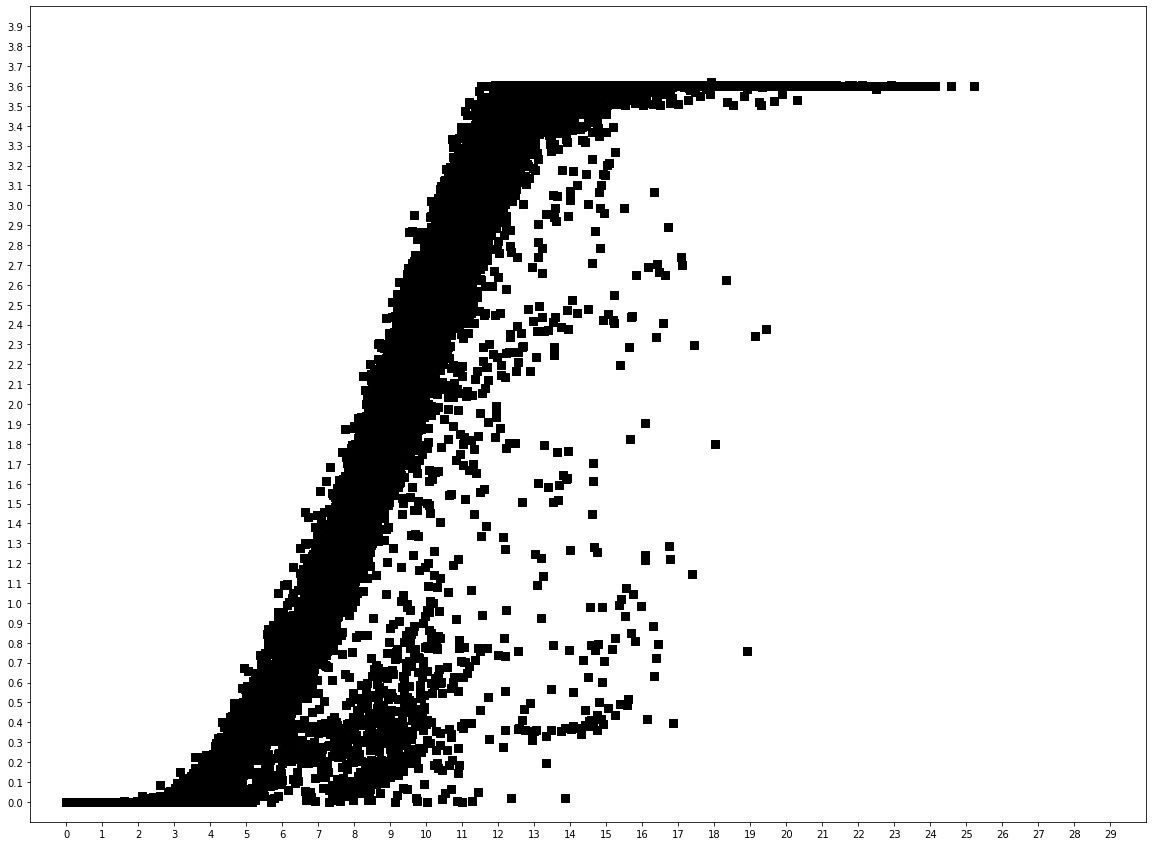

In [414]:
fname = 'D:/Birkbeck/Final Project/Practice/pwc_binary_plot.png'

plt.figure(figsize=(20,15))
plt.gcf().set_facecolor('white')
plt.scatter(filtered_data.iloc[:,2],filtered_data.iloc[:,1],marker='s',s=50,c='black')
plt.xticks(np.arange(0,30,1),c='black')
plt.yticks(np.arange(0,4,0.1),c='black')
plt.ylim(-0.1,4)
plt.xlim(-1,30)
plt.xlabel('Wind Speed (m/s)',c='white',visible=False)
plt.ylabel('LV ActivePower (MW)',c='white',visible=False)
plt.title('Power Curve',c='white',visible=False)
plt.savefig(fname, format='png')
plt.show()

### Outlier removal

In [415]:
normal_matrix = main(fname)

### Mapping data points on scatter

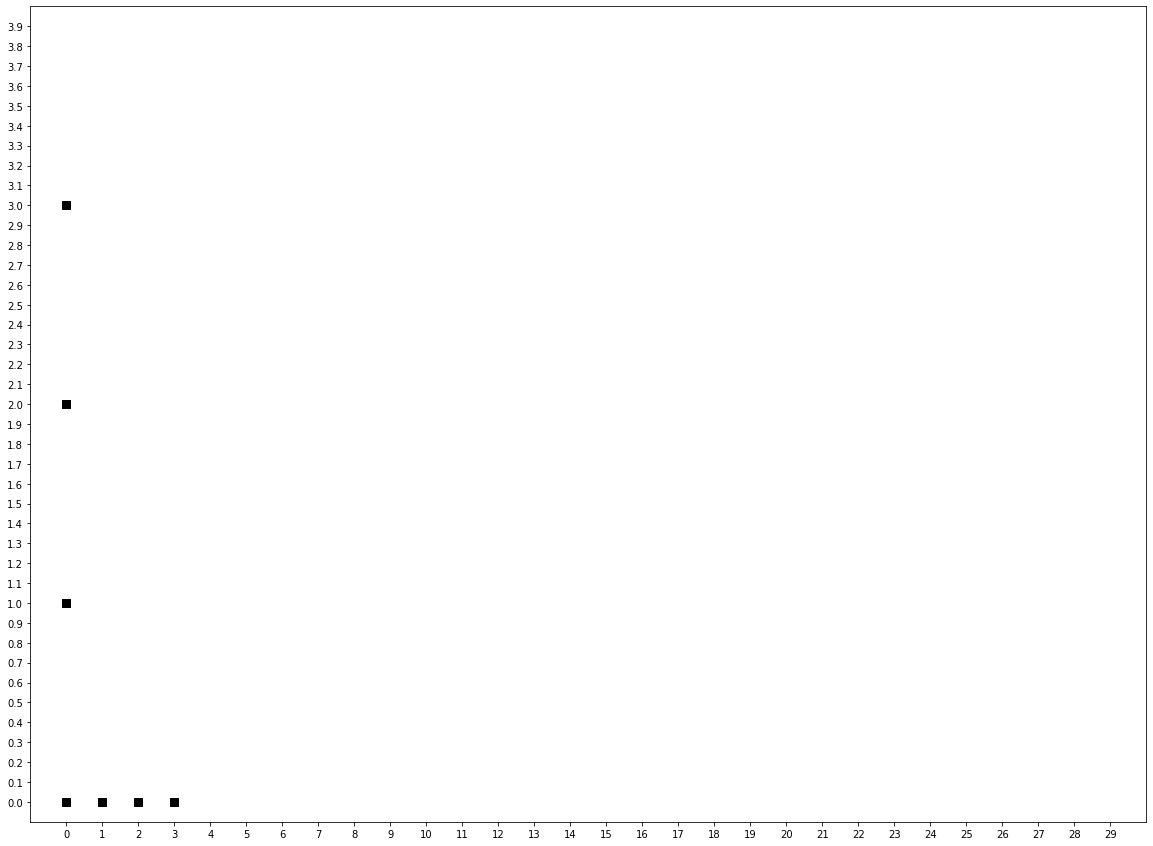

In [416]:
dummy_data = raw_data
# Vertical axis points
dummy_data.iloc[0,1] = 0
dummy_data.iloc[0,2] = 0
dummy_data.iloc[1,1] = 0
dummy_data.iloc[1,2] = 1
dummy_data.iloc[2,1] = 0
dummy_data.iloc[2,2] = 2
dummy_data.iloc[3,1] = 0
dummy_data.iloc[3,2] = 3
# Horizontal axis points
dummy_data.iloc[4,1] = 1
dummy_data.iloc[4,2] = 0
dummy_data.iloc[5,1] = 2
dummy_data.iloc[5,2] = 0
dummy_data.iloc[6,1] = 3
dummy_data.iloc[6,2] = 0
dummy_data = dummy_data.iloc[0:7,:]
# plot and save image
plt.figure(figsize=(20,15))
plt.gcf().set_facecolor('white')
#plt.scatter(filtered_data.iloc[:,2],filtered_data.iloc[:,1],marker='s',s=50,c='white')
plt.scatter(dummy_data.iloc[:,1],dummy_data.iloc[:,2],marker='s',s=50,c='black')
dfname = 'D:/Birkbeck/Final Project/Practice/dummy_data.png'
plt.xticks(np.arange(0,30,1),c='black')
plt.yticks(np.arange(0,4,0.1),c='black')
plt.ylim(-0.1,4)
plt.xlim(-1,30)
plt.xlabel(' ',c='white',visible=False)
plt.ylabel(' ',c='white',visible=False)
plt.title(' ',c='white',visible=False)
plt.savefig(dfname, format='png')
plt.show()

### Finding pixel locations of marker data points

In [418]:
img = read_file(dfname)
matrix = transform_image(img)
k = 726
y = 216
convert_to_image(matrix[k-100:k+100,y-100:y+100],False,'')

In [419]:
# scan for data points
for y in range(0,matrix.shape[1]):
    for k in range(0,matrix.shape[0]):
        if matrix[k,y] == 1 and matrix[k+4,y] == 1 and matrix[k,y+4] == 1 and matrix[k-4,y] == 1 and matrix[k,y-4] == 1 and matrix[k-5,y] == 0 and matrix[k,y-5] == 0 and matrix[k+5,y] == 0 and matrix[k,y+5] == 0:
            print(f'Location: {k},{y}')
            print(matrix[k-15:k+15,y-15:y+15])

Location: 328,216
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1

In [309]:
# pixel locations of each tick
yticks = [925-(x*199) for x in range(0,5)]
xticks = [216+(x*36) for x in range(0,30)]
print(yticks)
print(xticks)

[925, 726, 527, 328, 129]
[216, 252, 288, 324, 360, 396, 432, 468, 504, 540, 576, 612, 648, 684, 720, 756, 792, 828, 864, 900, 936, 972, 1008, 1044, 1080, 1116, 1152, 1188, 1224, 1260]


In [483]:
# subticks additions
xsubticks = [round(x/10) for x in range(36,396-36,36)]
ysubticks = [round(x/10) for x in range(199,2189-199,199)]
print(xsubticks)
print(ysubticks)

[4, 7, 11, 14, 18, 22, 25, 29, 32]
[20, 40, 60, 80, 100, 119, 139, 159, 179]


### Marking boundaries of normal data points

In [420]:
img = read_file('D:/Birkbeck/Final Project/Practice/pwc_binary_plot_transformed.png')
matrix = transform_image(img)

In [463]:
# visualise section of scatter
k = 929
y = 330
s = 200
#convert_to_image(matrix[k-s:k+s,y-s:y+s],False,'')
convert_to_image(matrix,False,'')

In [460]:
# remove leftover marks on scatter
matrix[950:955,1142:1155] = 0

In [461]:
# scan each row of matrix to find leftover 1's to clean
for k in range(matrix.shape[0]-1,0,-1):
    for y in range(matrix.shape[1]-1,0,-1):
        if matrix[k,y] == 1:
            print(f'Location: {k},{y}')
            print(matrix[k-15:k+15,y-15:y+15])
            break

Location: 929,330
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0

In [464]:
# Extract starting points horizontally from left
L_horizontal = []
for k in range(0,matrix.shape[0]):
    val = 0
    for y in range(0,matrix.shape[1]):
        if matrix[k,y] == 1:
            val = y+4
            break
    L_horizontal.append(val)
# Extract starting points horizontally from right
R_horizontal = []
for k in range(0,matrix.shape[0]):
    val = 0
    for y in range(matrix.shape[1]-1,0,-1):
        if matrix[k,y] == 1:
            val = y-4
            break
    R_horizontal.append(val)

In [467]:
# create a test matrix to see if shape is captured properly
test_matrix = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=np.uint8)
for i,k in enumerate(range(0,matrix.shape[0])):
    if L_horizontal[i] != 0:
        test_matrix[k,L_horizontal[i]:L_horizontal[i]+5] = 1
    if R_horizontal[i] != 0:
        test_matrix[k,R_horizontal[i]-5:R_horizontal[i]] = 1
    if L_horizontal[i] != 0 and R_horizontal[i] != 0:
        test_matrix[k,L_horizontal[i]:R_horizontal[i]] = 1
# visualise test_matrix
convert_to_image(test_matrix,False,'')

### Create pixel to coord conversion functions

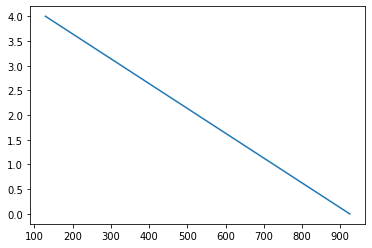

In [513]:
from sklearn.linear_model import LinearRegression
X = np.array(yticks)
y = [0,1,2,3,4]
X = X.reshape(-1,1)
Y_pixel_converter = LinearRegression()
Y_pixel_converter.fit(X,y)
pred = Y_pixel_converter.predict(X)
plt.plot(yticks,pred)
plt.show()

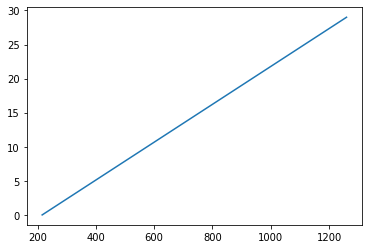

In [516]:
X = np.array(xticks)
y = [x for x in range(0,30)]
X = X.reshape(-1,1)
X_pixel_converter = LinearRegression()
X_pixel_converter.fit(X,y)
pred = X_pixel_converter.predict(X)
plt.plot(xticks,pred)
plt.show()

### Convert pixels into values

In [543]:
# turn pixel plots into DF
df = pd.DataFrame({'LH':L_horizontal,'RH':R_horizontal},index=None)
df['LH-X'] = X_pixel_converter.predict(np.array(df['LH'].values.tolist()).reshape(-1,1))
df['RH-X'] = X_pixel_converter.predict(np.array(df['RH'].values.tolist()).reshape(-1,1))
df['Y'] = Y_pixel_converter.predict(np.array(df.index.values.tolist()).reshape(-1,1))

In [544]:
df = df[(df['LH-X']>=0)&(df['RH-X']>=0)&(df['Y']>=0)]
df

,LH,RH,LH-X,RH-X,Y
201,861,860,1.791667e+01,17.888889,3.638191
202,861,860,1.791667e+01,17.888889,3.633166
203,861,860,1.791667e+01,17.888889,3.628141
204,669,750,1.258333e+01,14.833333,3.623116
205,912,1084,1.933333e+01,24.111111,3.618090
...,...,...,...,...,...
921,216,391,4.440892e-15,4.861111,0.020101
922,216,391,4.440892e-15,4.861111,0.015075
923,216,391,4.440892e-15,4.861111,0.010050
924,216,391,4.440892e-15,4.861111,0.005025


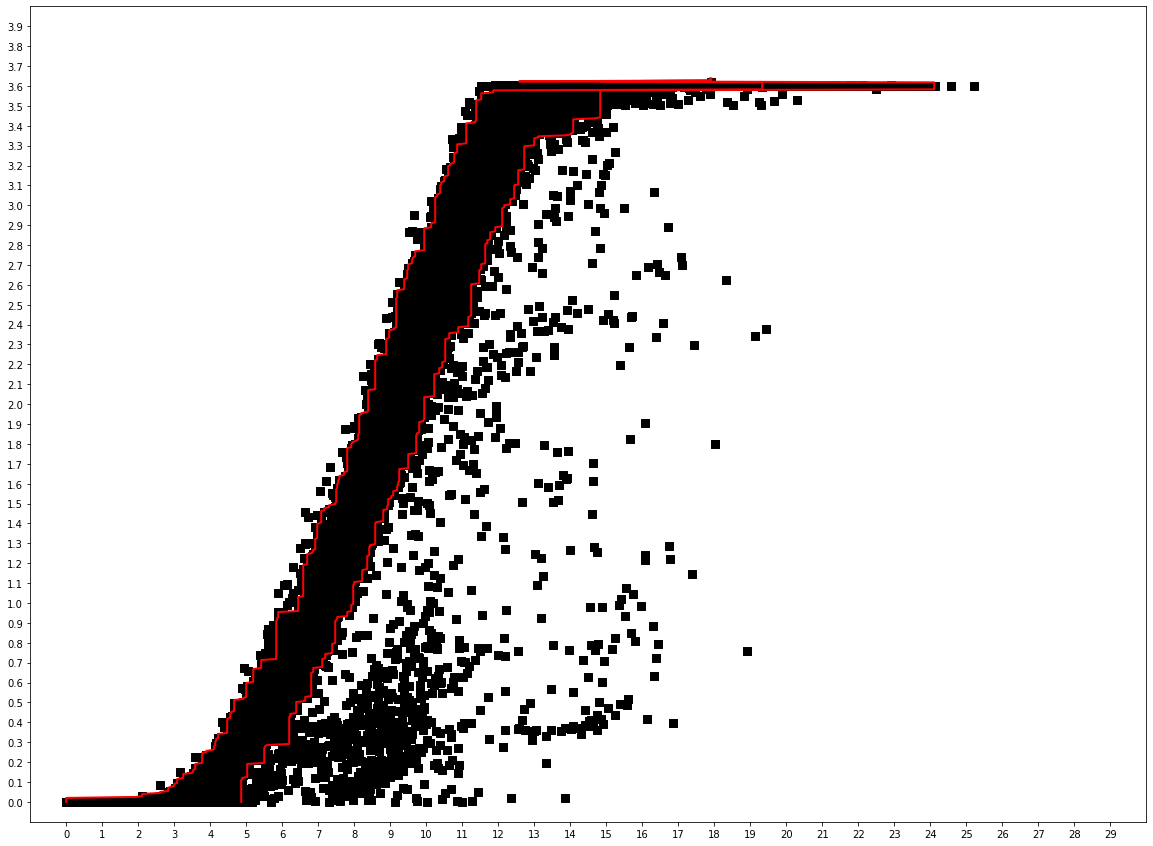

In [536]:
# visualise data in scatter
plt.figure(figsize=(20,15))
plt.gcf().set_facecolor('white')
plt.scatter(filtered_data.iloc[:,2],filtered_data.iloc[:,1],marker='s',s=50,c='black')
plt.plot(df.iloc[:,2],df.iloc[:,4],c='red',lw=2)#,marker='s',s=50,c='red')
plt.plot(df.iloc[:,3],df.iloc[:,4],c='red',lw=2)#,marker='s',s=50,c='red')
plt.xticks(np.arange(0,30,1),c='black')
plt.yticks(np.arange(0,4,0.1),c='black')
plt.ylim(-0.1,4)
plt.xlim(-1,30)
plt.xlabel('Wind Speed (m/s)',c='white',visible=False)
plt.ylabel('LV ActivePower (MW)',c='white',visible=False)
plt.title('Power Curve',c='white',visible=False)
plt.show()

### Classify data as normal/outlier

In [593]:
# create col in 2 decimal places
processing_data = raw_data
processing_data['Y_val'] = processing_data['LV ActivePower (MW)'].round(decimals=2)
processing_data['X_val'] = processing_data['Wind Speed (m/s)'].round(decimals=2)
processing_data

,Date/Time,LV ActivePower (MW),Wind Speed (m/s),Wind Direction (°),Y_val,X_val
0,2018-01-01 00:00:00,0.380048,5.311336,259.994904,0.38,5.31
1,2018-01-01 00:10:00,0.453769,5.672167,268.641113,0.45,5.67
2,2018-01-01 00:20:00,0.306377,5.216037,272.564789,0.31,5.22
3,2018-01-01 00:30:00,0.419646,5.659674,271.258087,0.42,5.66
4,2018-01-01 00:40:00,0.380651,5.577941,265.674286,0.38,5.58
...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2.963981,11.404030,80.502724,2.96,11.40
50526,2018-12-31 23:20:00,1.684353,7.332648,84.062599,1.68,7.33
50527,2018-12-31 23:30:00,2.201107,8.435358,84.742500,2.20,8.44
50528,2018-12-31 23:40:00,2.515694,9.421366,84.297913,2.52,9.42


In [545]:
# create col in 2 decimal places
df['Y_r'] = df['Y'].round(decimals=2)
df['LH-X_r'] = df['LH-X'].round(decimals=2)
df['RH-X_r'] = df['RH-X'].round(decimals=2)
df

,LH,RH,LH-X,RH-X,Y,Y_r,LH-X_r,RH-X_r
201,861,860,1.791667e+01,17.888889,3.638191,3.64,17.92,17.89
202,861,860,1.791667e+01,17.888889,3.633166,3.63,17.92,17.89
203,861,860,1.791667e+01,17.888889,3.628141,3.63,17.92,17.89
204,669,750,1.258333e+01,14.833333,3.623116,3.62,12.58,14.83
205,912,1084,1.933333e+01,24.111111,3.618090,3.62,19.33,24.11
...,...,...,...,...,...,...,...,...
921,216,391,4.440892e-15,4.861111,0.020101,0.02,0.00,4.86
922,216,391,4.440892e-15,4.861111,0.015075,0.02,0.00,4.86
923,216,391,4.440892e-15,4.861111,0.010050,0.01,0.00,4.86
924,216,391,4.440892e-15,4.861111,0.005025,0.01,0.00,4.86


In [594]:
# check if subset
set_A = set(processing_data['Y_val'].unique())
set_B = set(df['Y_r'].unique()) 
set_A <= set_B

True

In [595]:
processing_data['Class'] = 1
# for each instance Y value, check if X value is more than max X or less than min X, class = outlier
for i,row in processing_data.iterrows():
    Y = row['Y_val']
    x_max = df[df['Y_r']==Y]['RH-X_r'].max()
    x_min = df[df['Y_r']==Y]['LH-X_r'].min()
    if row['X_val'] < x_max and row['X_val'] > x_min:
        processing_data.iloc[i,-1] = 0

In [596]:
processing_data.head(40)
processing_data['Class'].value_counts()

0    43671
1     6859
Name: Class, dtype: int64

### Plot the normal vs outliers

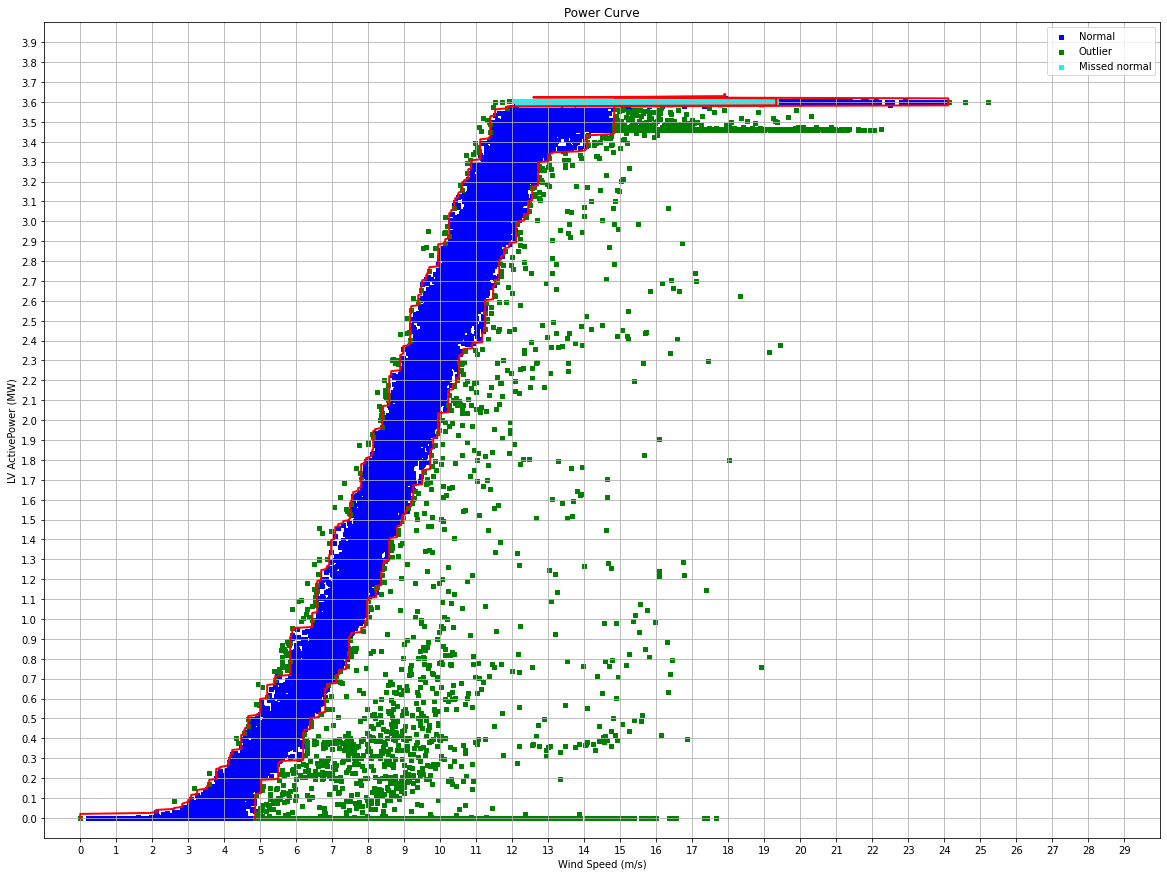

In [597]:
# Prepare data
normal = processing_data[processing_data['Class'] == 0]
outlier = processing_data[processing_data['Class'] == 1]
missed = outlier[(outlier['Y_val']>3.57)&(outlier['X_val']>12)&(outlier['X_val']<23)]
# visualise data in scatter
plt.figure(figsize=(20,15))
plt.scatter(normal.iloc[:,2],normal.iloc[:,1],marker='s',s=10,c='blue',label='Normal')
plt.scatter(outlier.iloc[:,2],outlier.iloc[:,1],marker='s',s=10,c='green',label='Outlier')
plt.scatter(missed.iloc[:,2],missed.iloc[:,1],marker='s',s=10,c='cyan',label='Missed normal')
plt.plot(df.iloc[:,2],df.iloc[:,4],c='red',lw=2)
plt.plot(df.iloc[:,3],df.iloc[:,4],c='red',lw=2)
plt.xticks(np.arange(0,30,1),c='black')
plt.yticks(np.arange(0,4,0.1),c='black')
plt.ylim(-0.1,4)
plt.xlim(-1,30)
plt.xlabel('Wind Speed (m/s)',c='black')
plt.ylabel('LV ActivePower (MW)',c='black')
plt.title('Power Curve',c='black')
plt.grid()
plt.legend()
plt.show()